In [1]:
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [4]:
records = lidar.load_records(sync=False)

Unable to determine range 2
Unable to determine range 1


In [5]:
import functools
from enum import Enum
import pprint

@functools.total_ordering
class Extremum(object):
    class Concavity(Enum):
        MINIMUM = -1
        INFLECT =  0
        MAXIMUM =  1
        
    def __init__(self, index, concavity, value):
        self.index = index
        self.concavity = concavity
        self.value = value
        
    def __eq__(self, other):
        return self.index == other.index
    
    def __lt__(self, other):
        return self.index < other.index

In [6]:
import itertools
import collections

def window(iterator, size=2):
    if not isinstance(iterator, collections.Iterator):
        iterator = iter(iterator)
    
    result = tuple(itertools.islice(iterator, size))
    if len(result) == size:
        yield result
    for elem in iterator:
        result = result[1:] + (elem,)
        yield result
    
def is_pattern(window):
    if len(window) == 3:
        return window[1] > window[0] and window[1] > window[2]
    return False
    
a = [1, 2, 3, 5, 6, 7, 9, 0, 1]
for w in window(a, 3):
    print(w)
    print('pattern?', is_pattern(w))

(1, 2, 3)
pattern? False
(2, 3, 5)
pattern? False
(3, 5, 6)
pattern? False
(5, 6, 7)
pattern? False
(6, 7, 9)
pattern? False
(7, 9, 0)
pattern? True
(9, 0, 1)
pattern? False


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


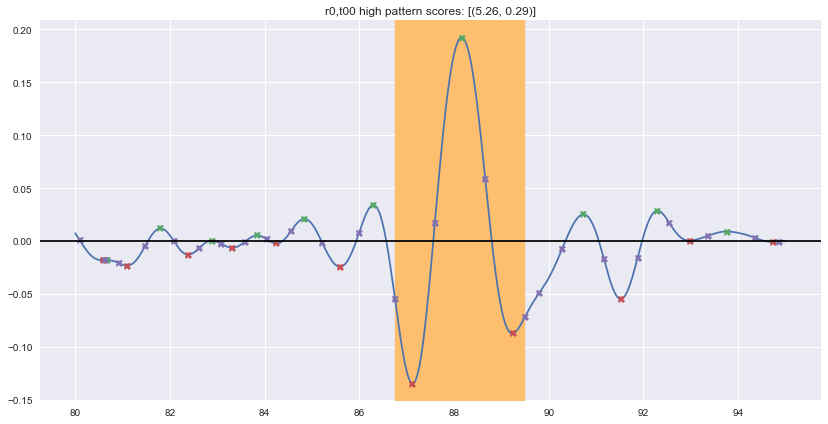

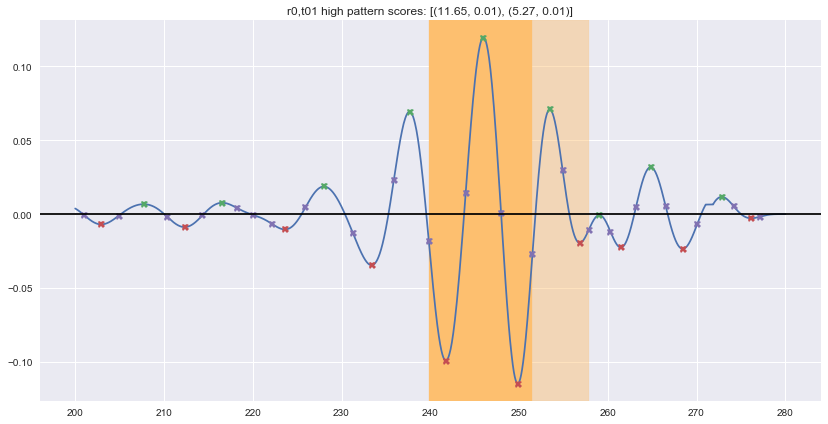

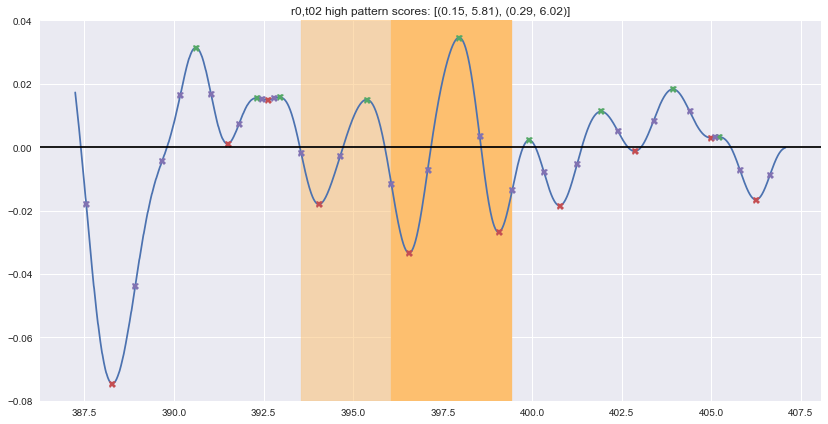

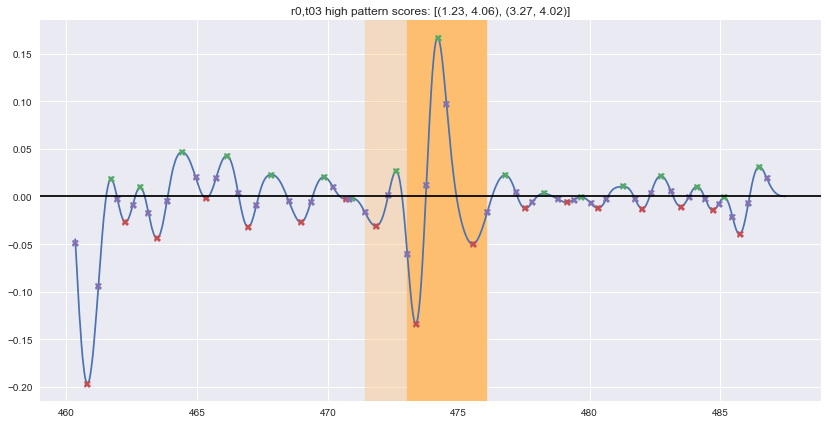

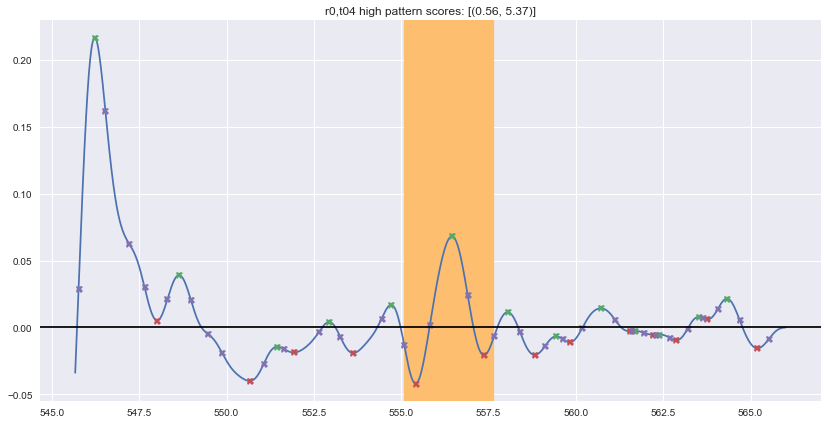

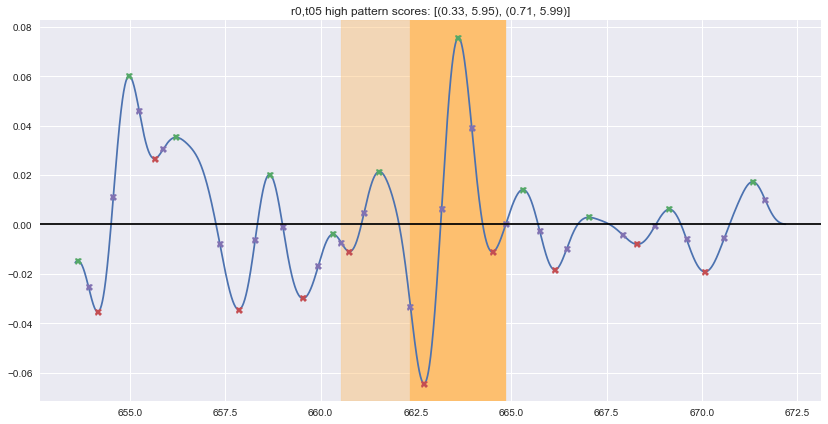

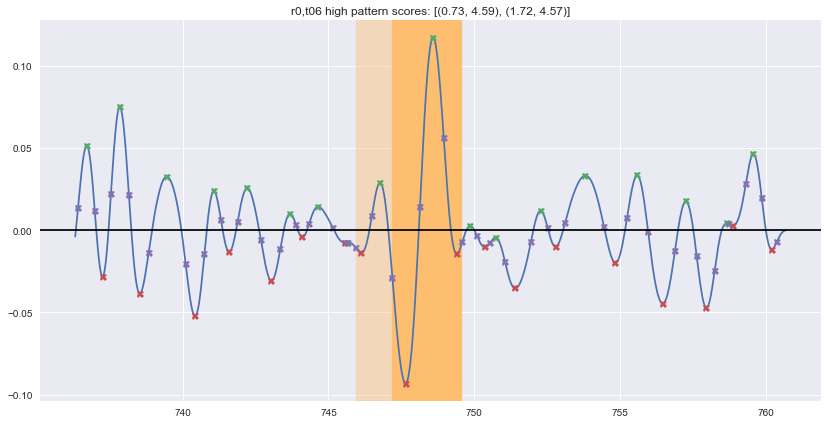

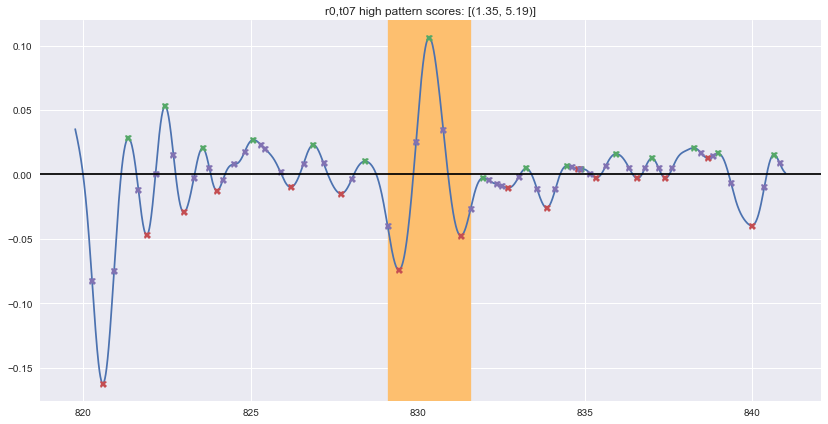

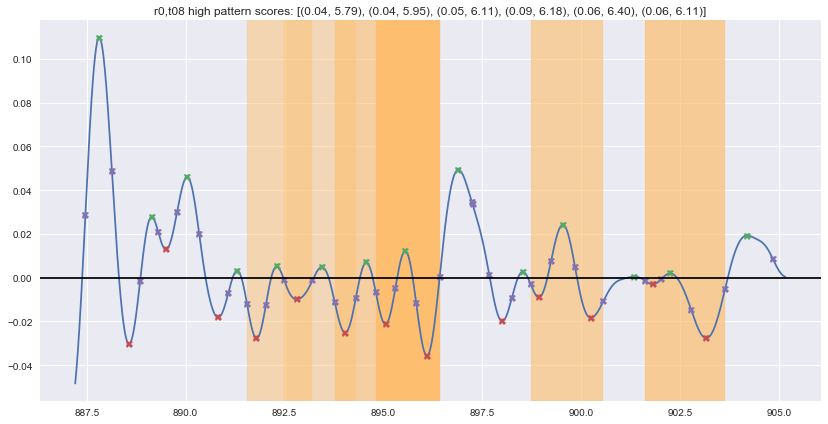

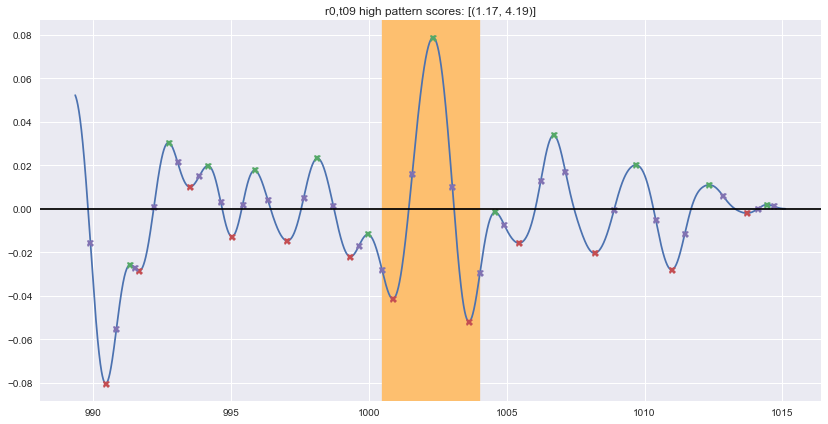

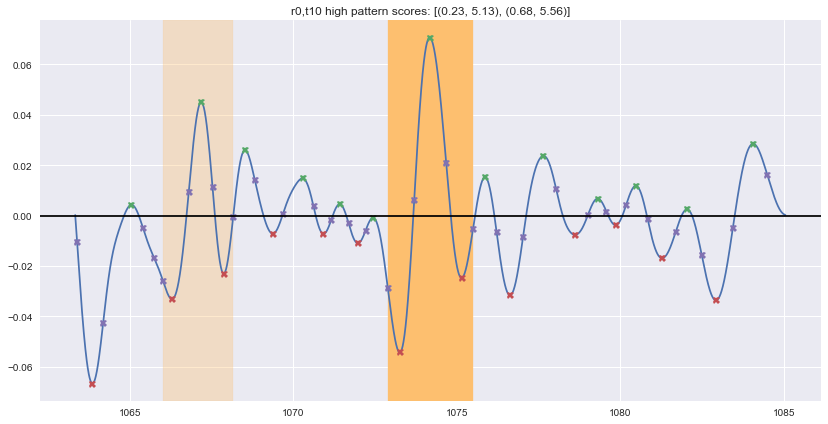

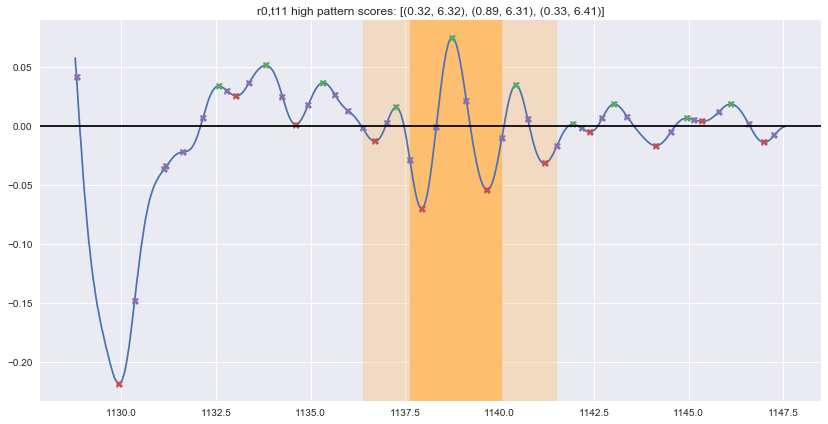

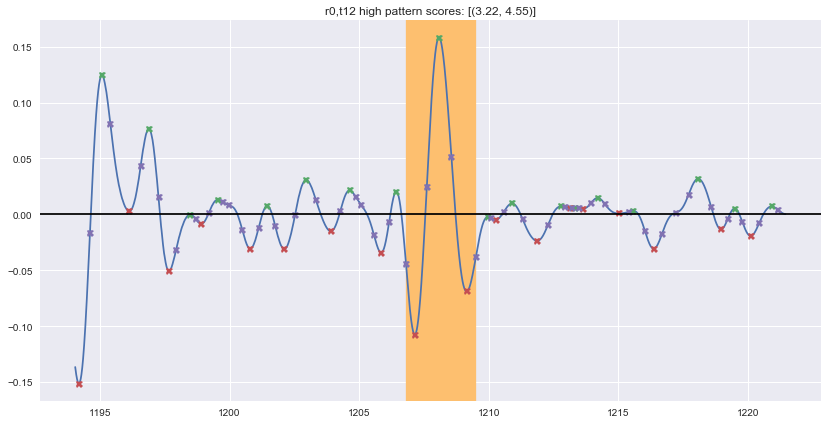

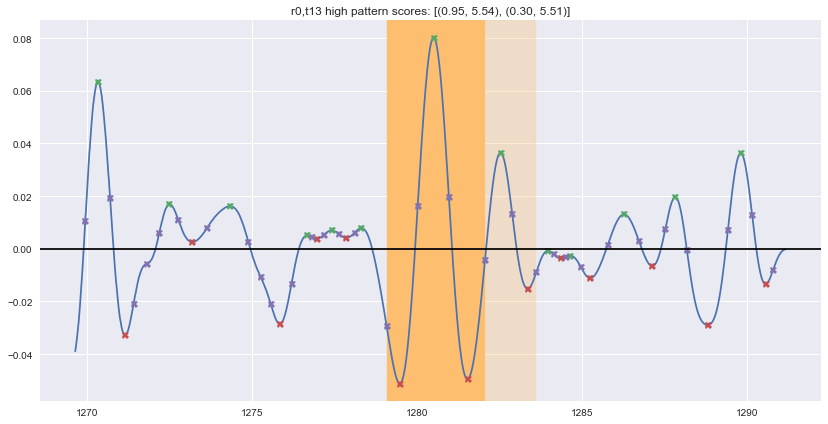

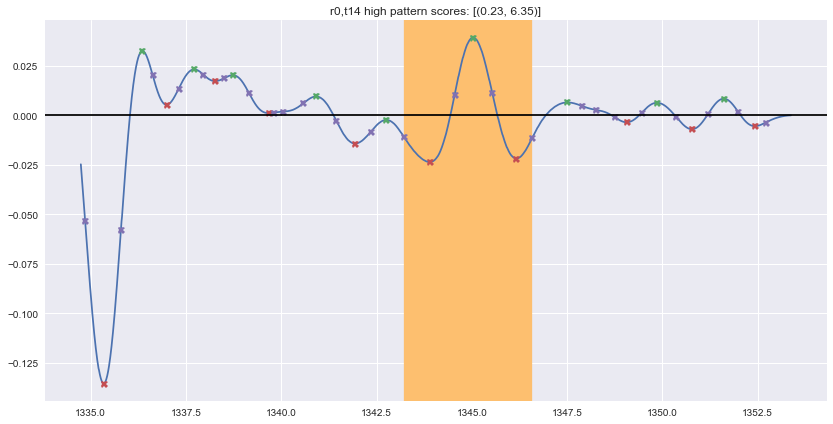

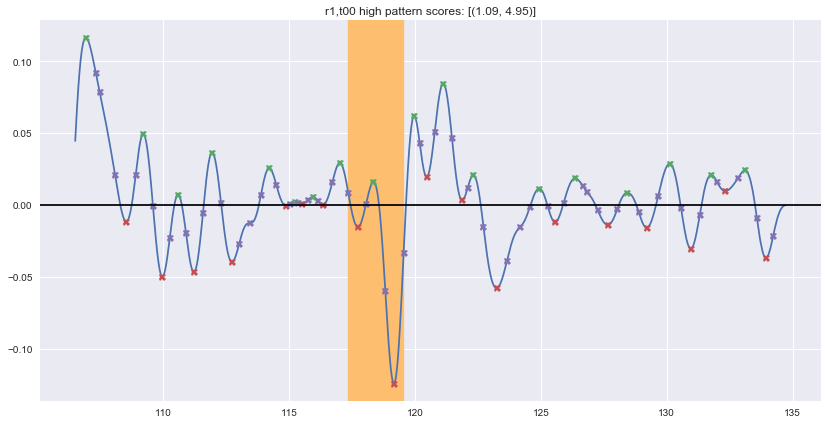

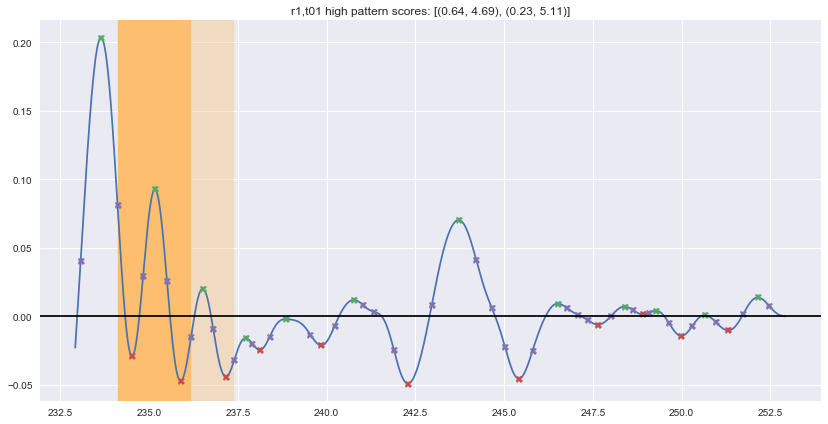

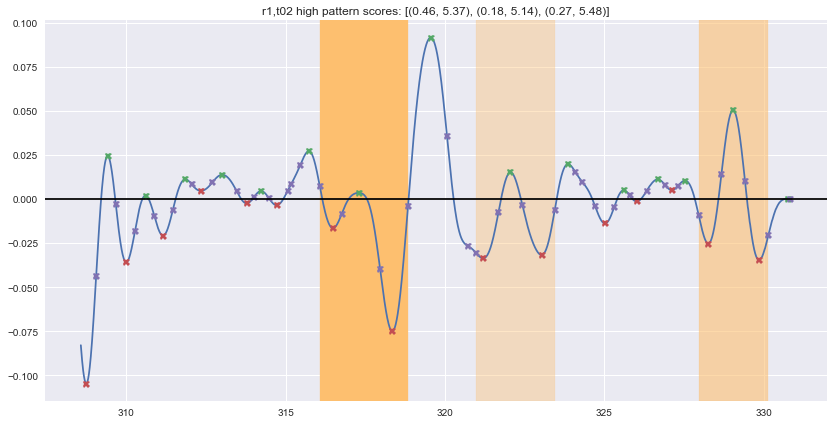

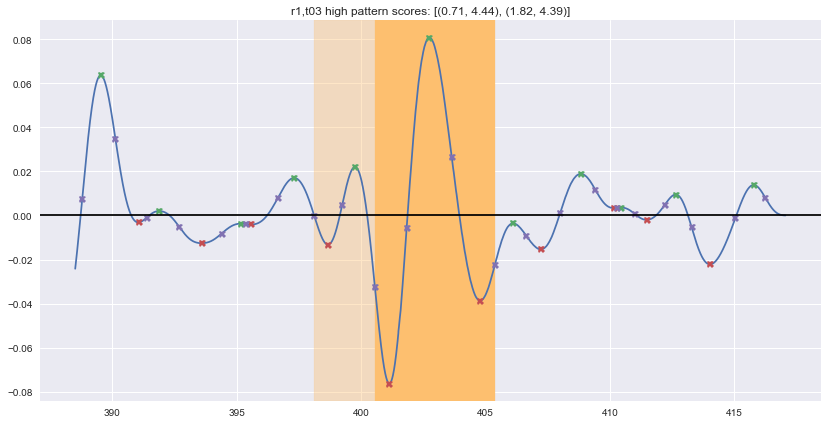

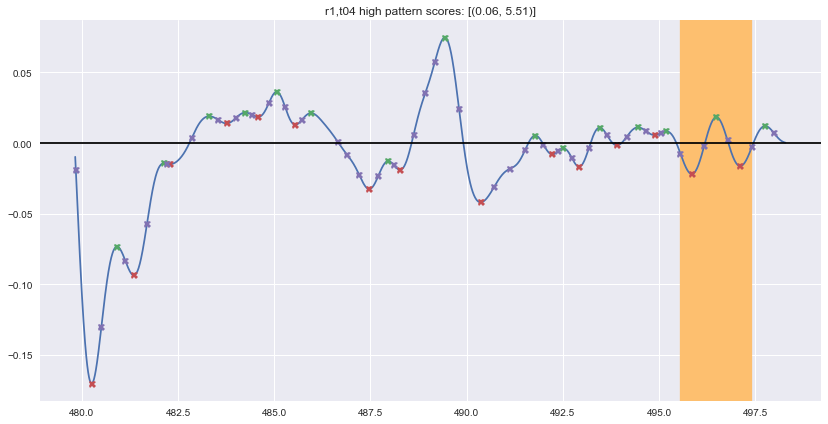

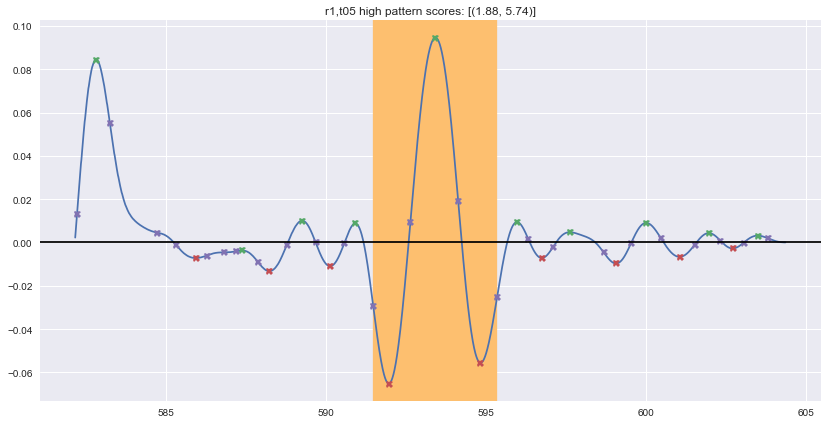

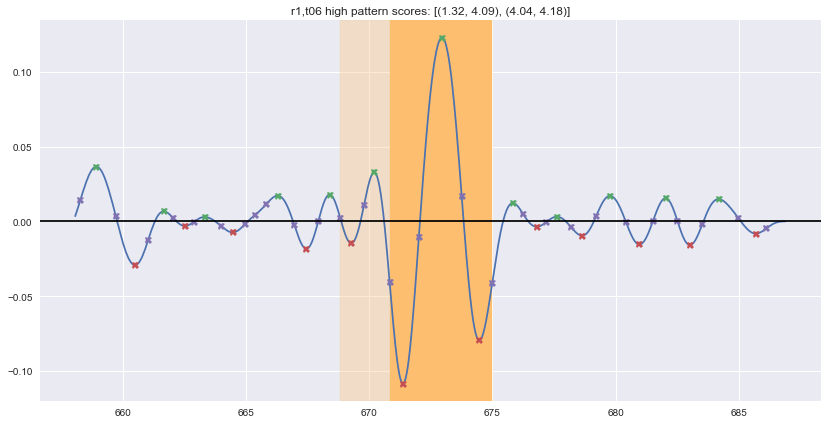

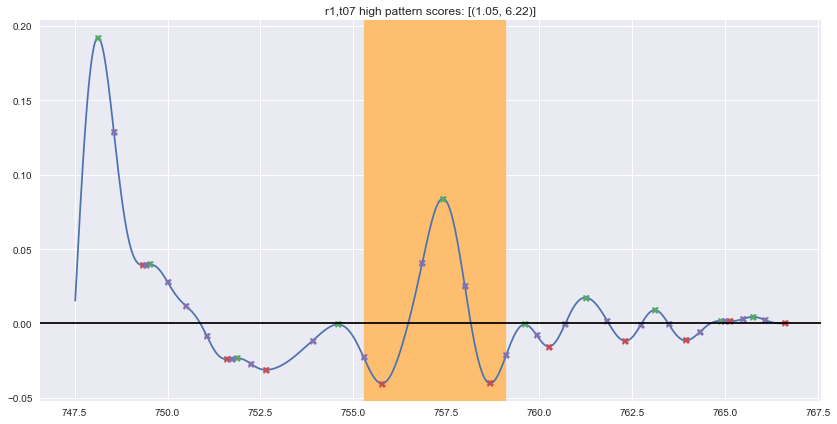

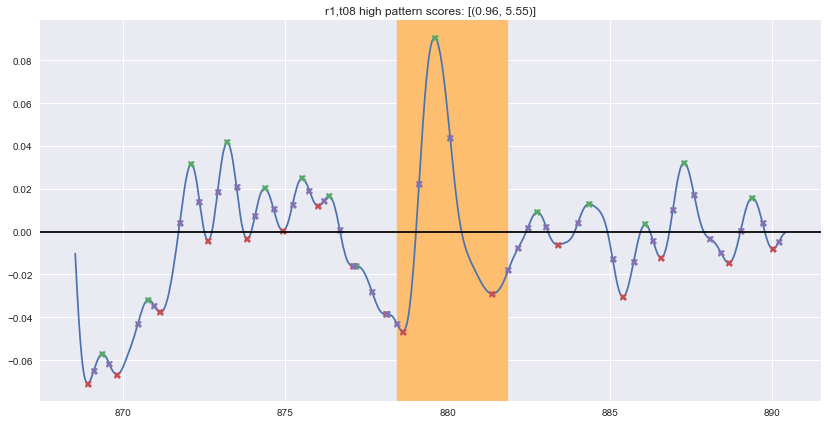

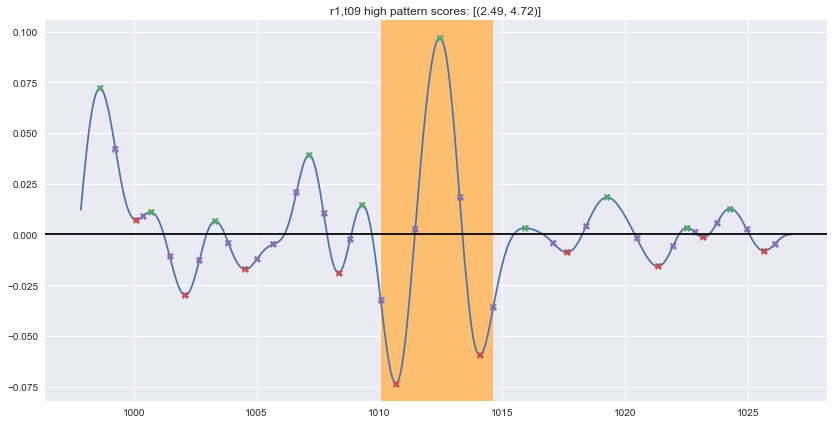

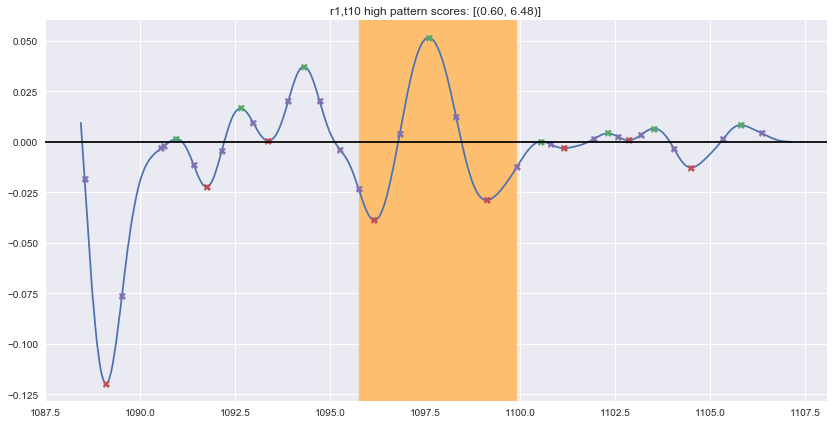

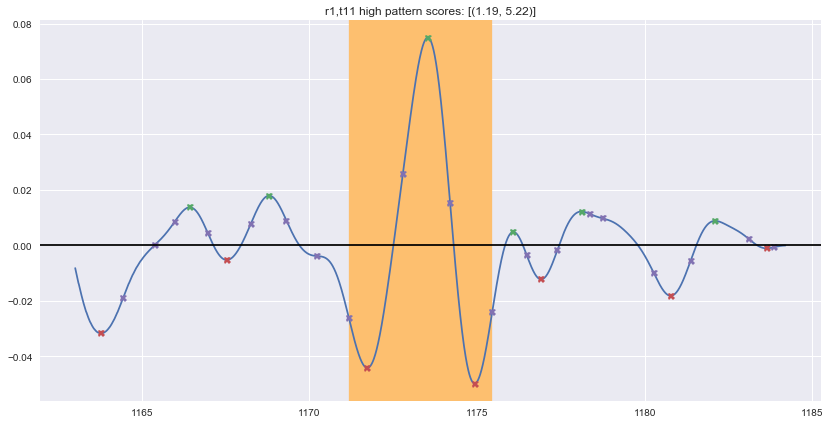

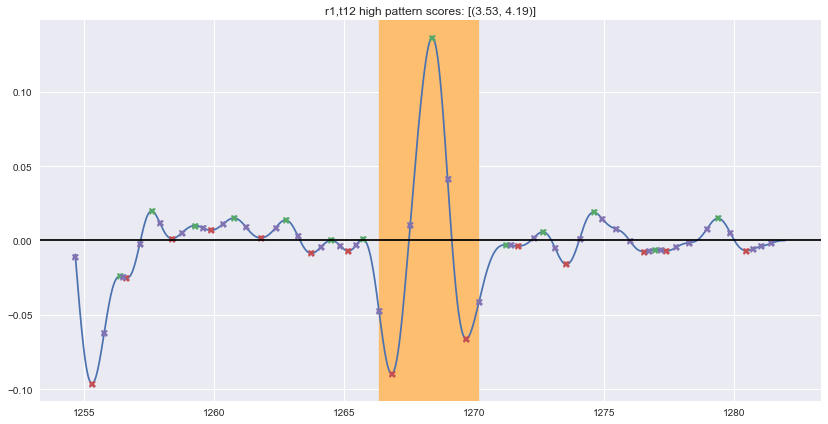

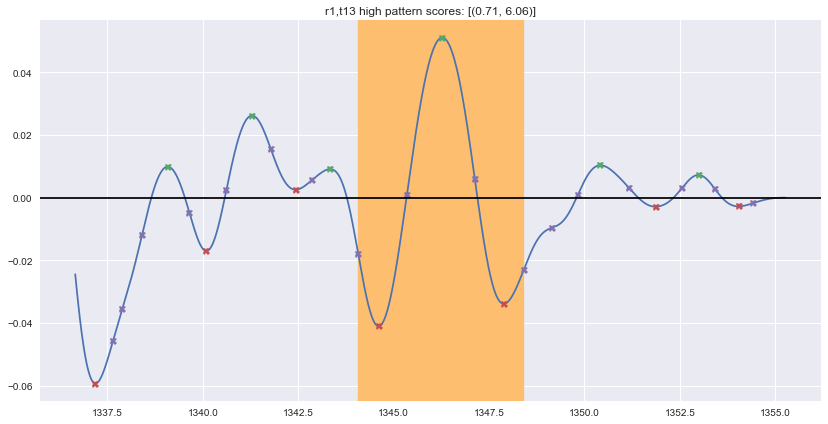

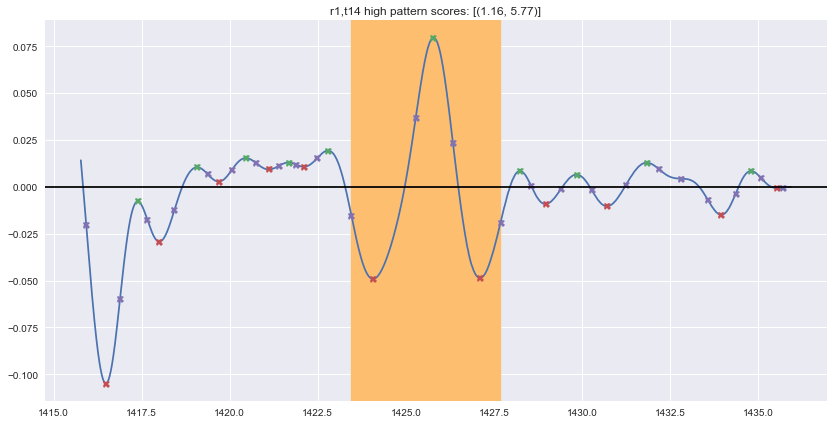

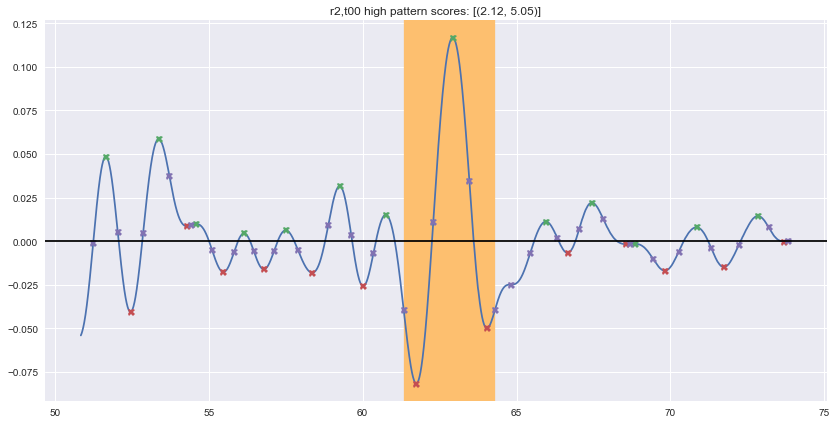

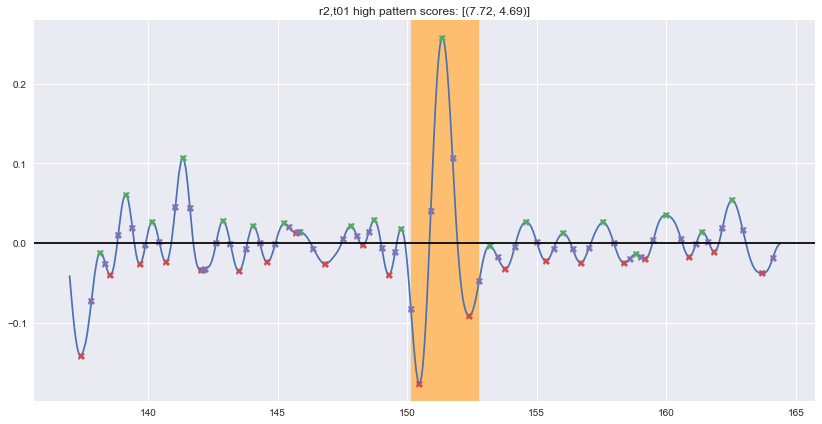

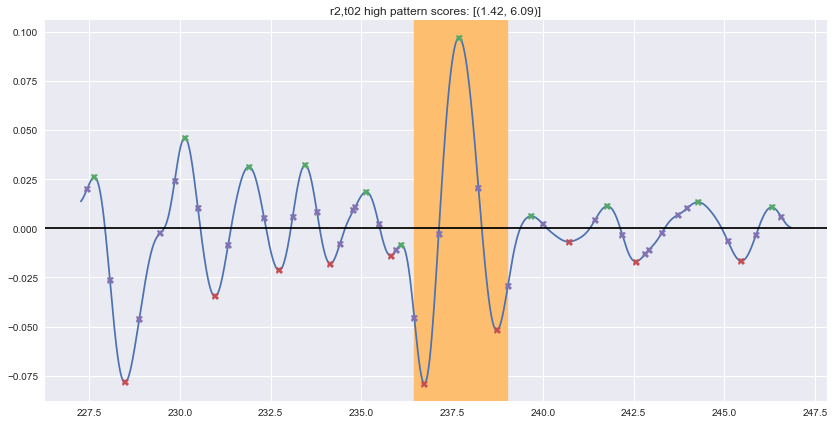

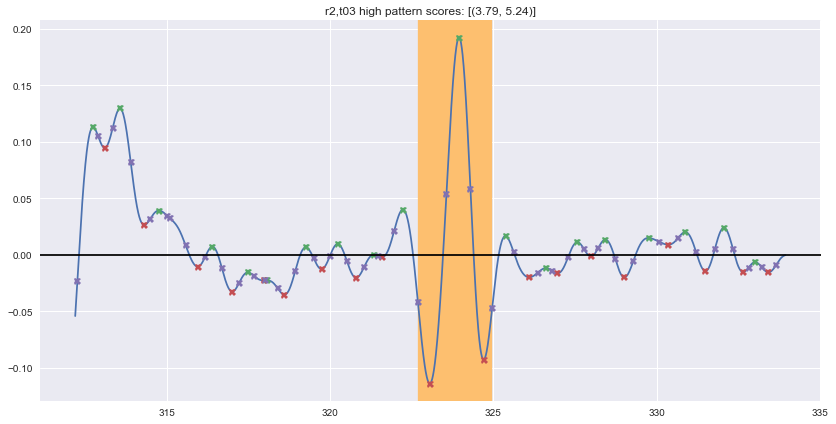

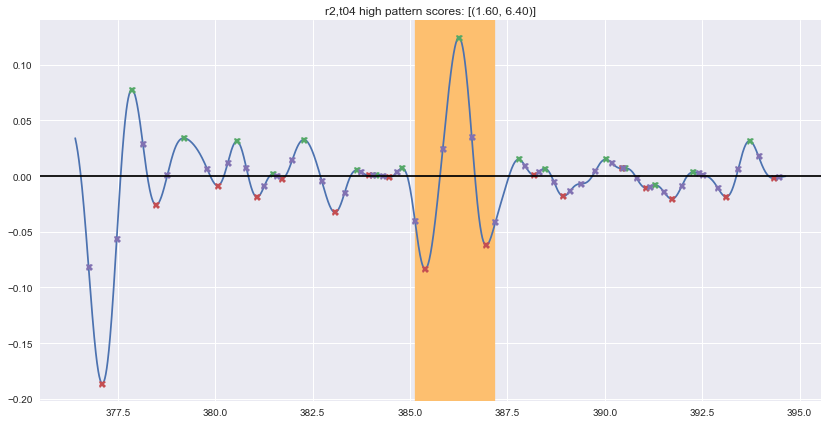

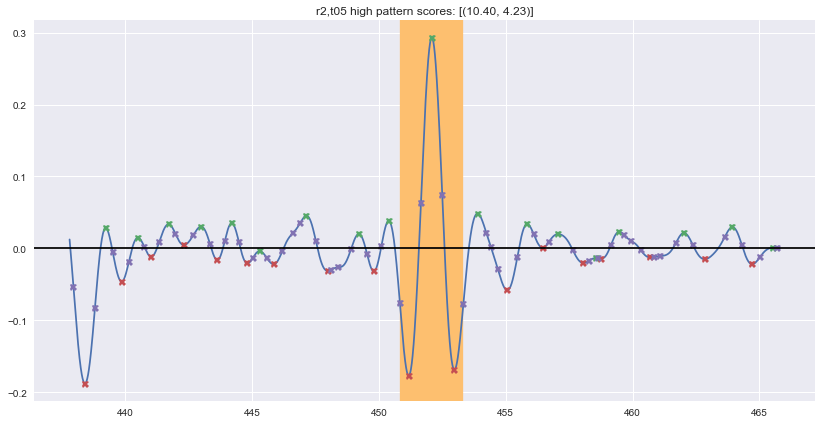

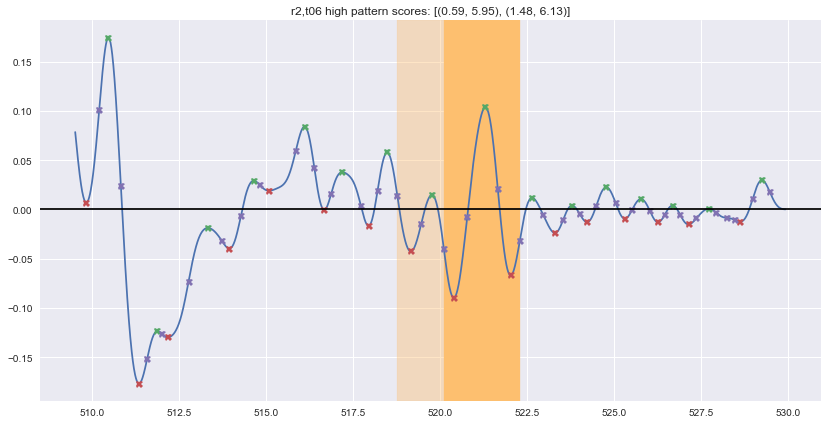

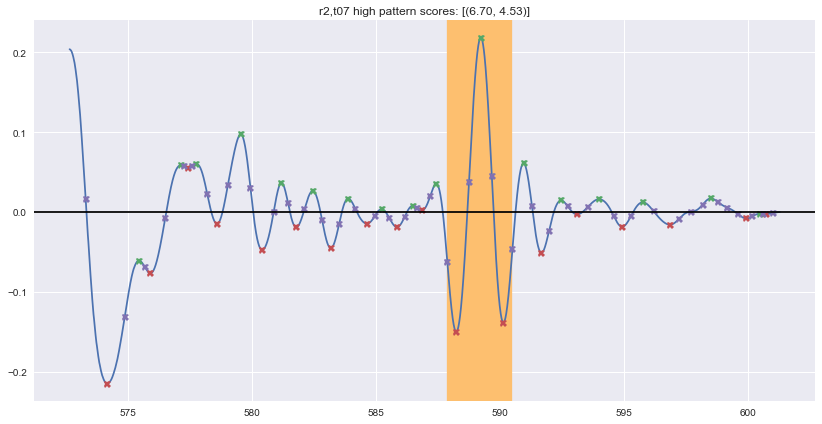

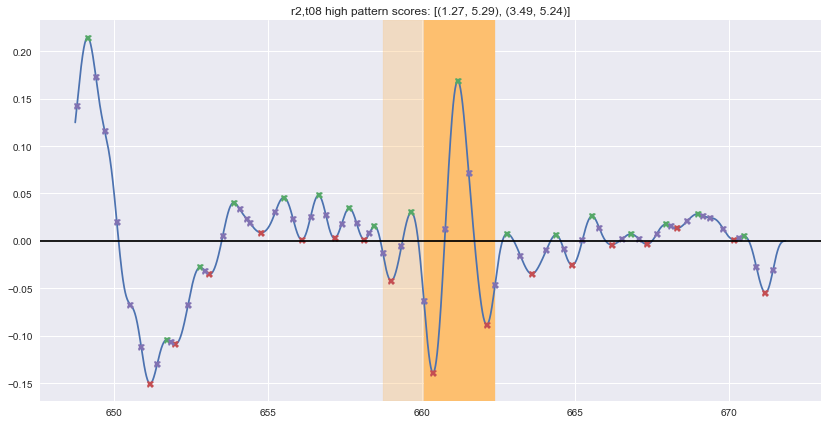

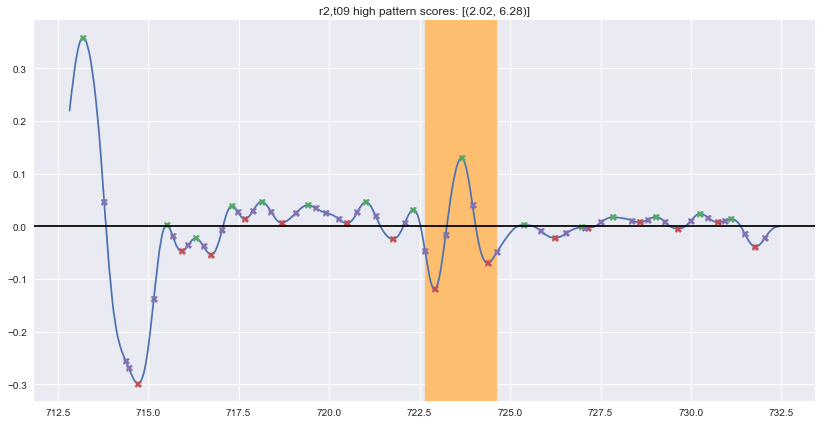

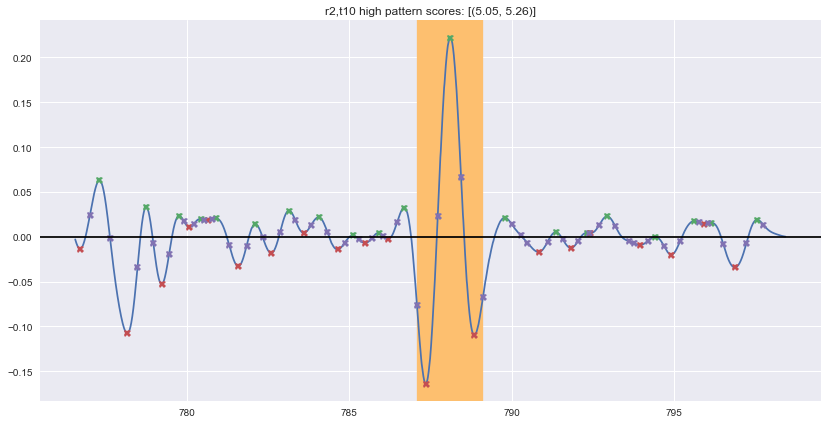

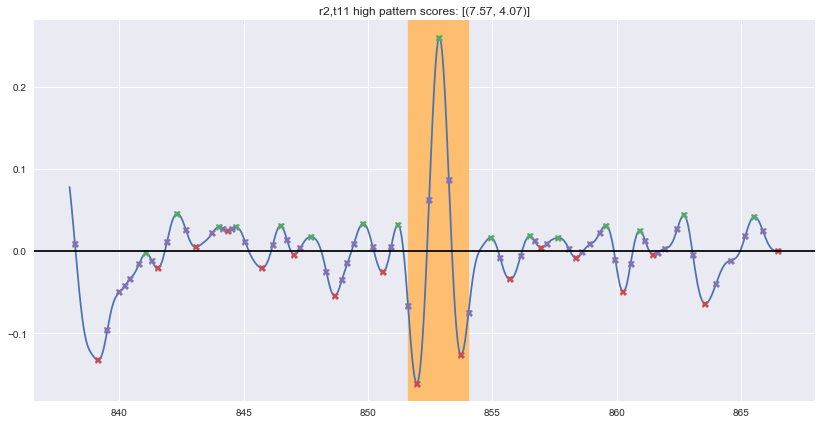

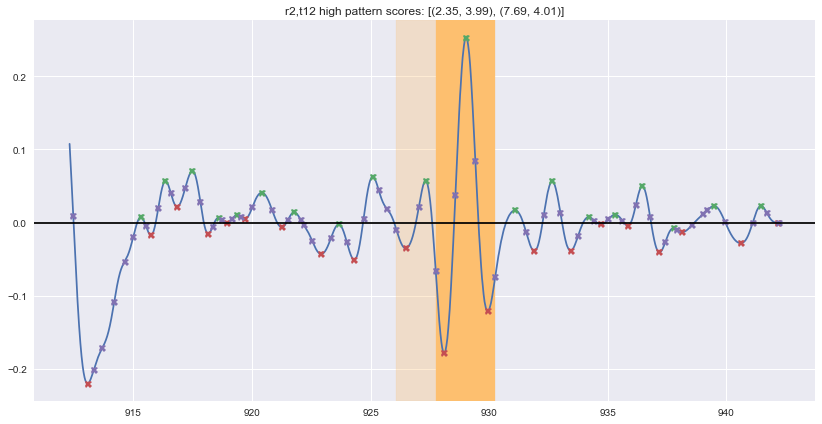

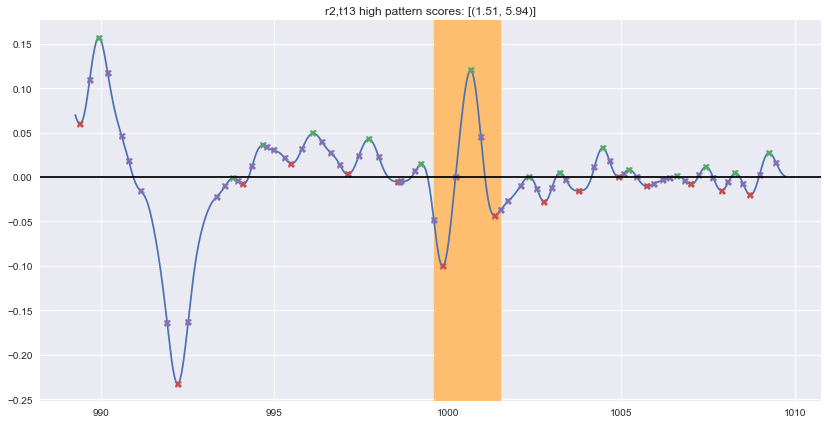

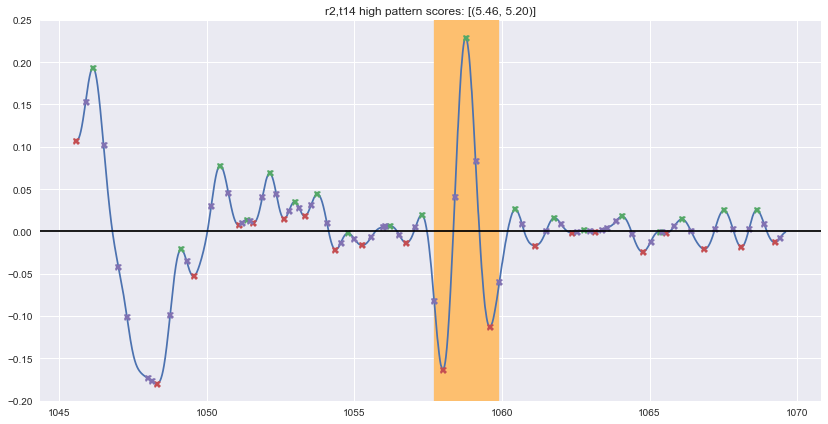

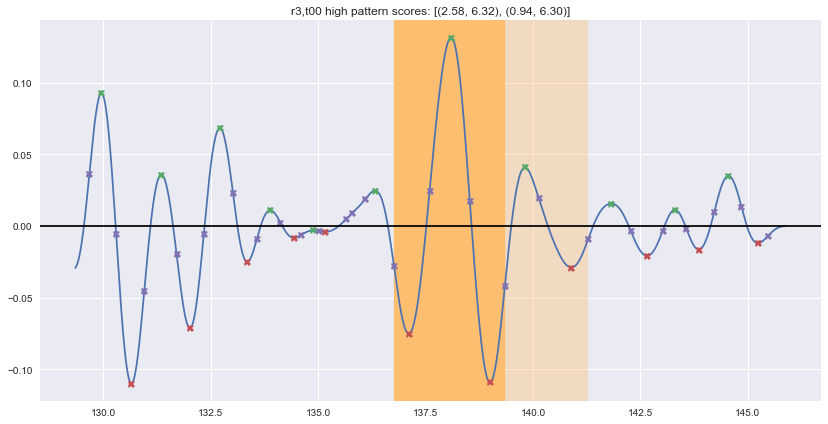

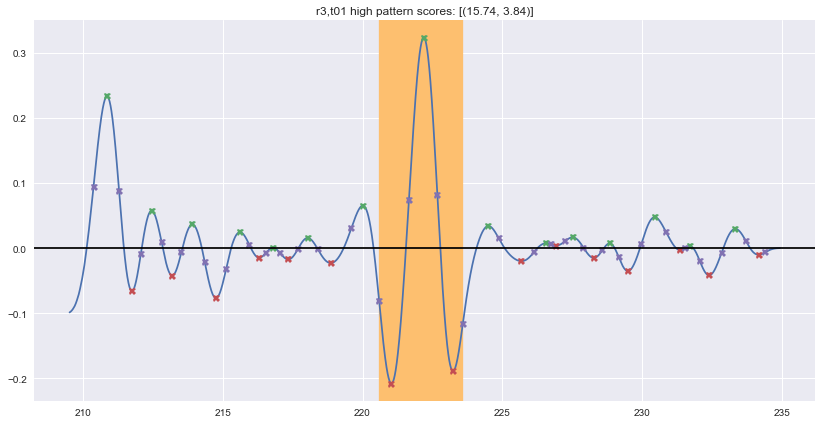

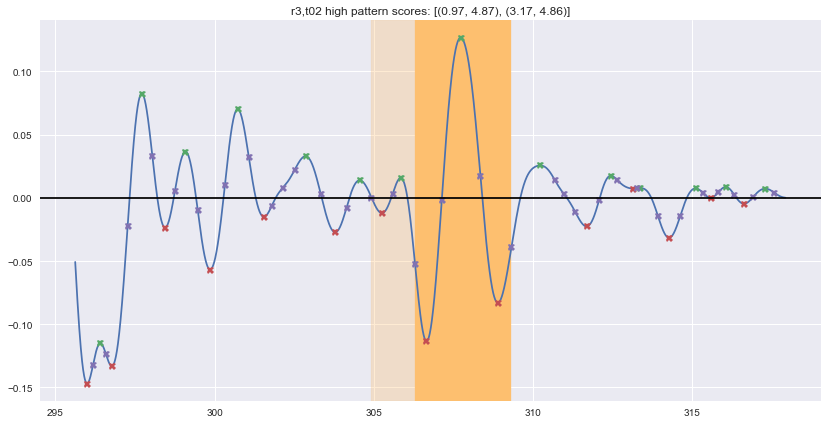

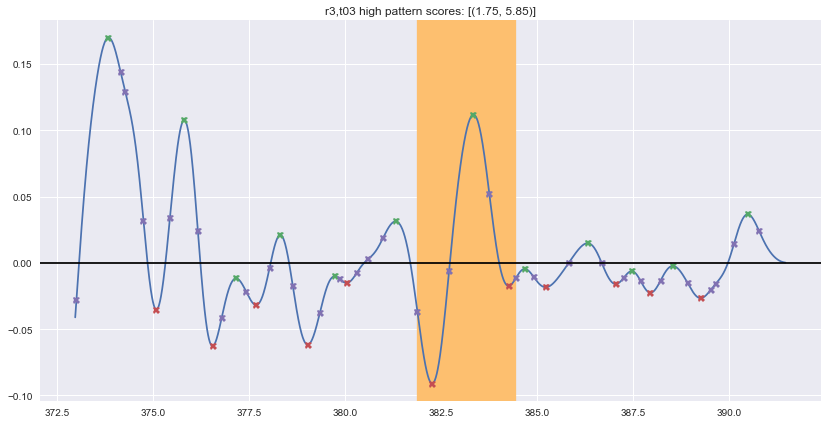

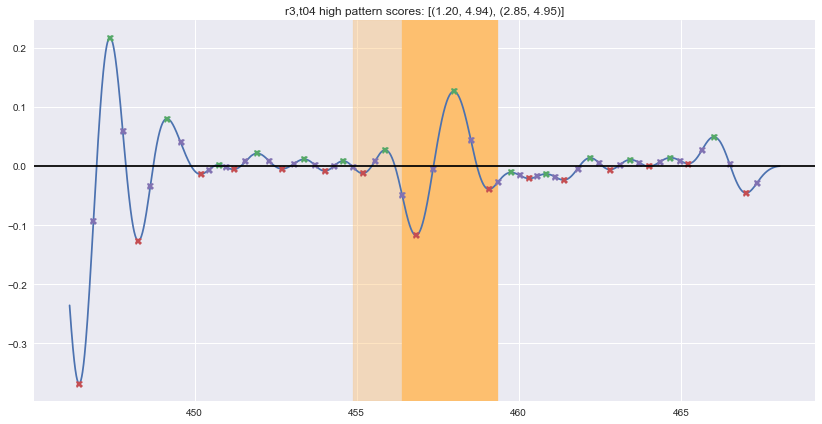

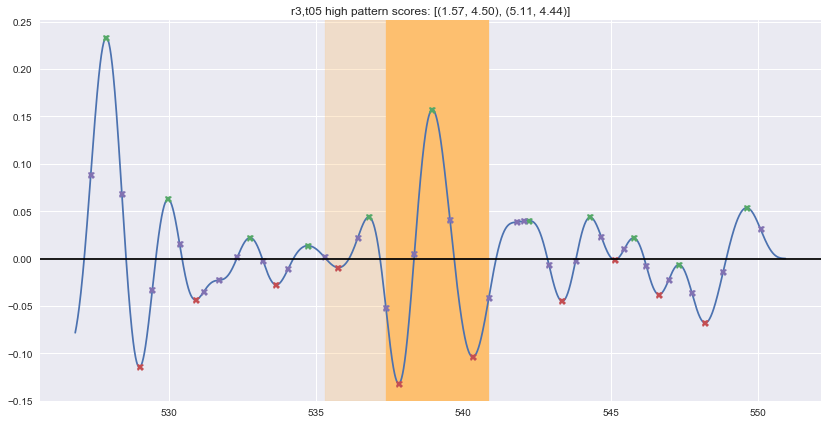

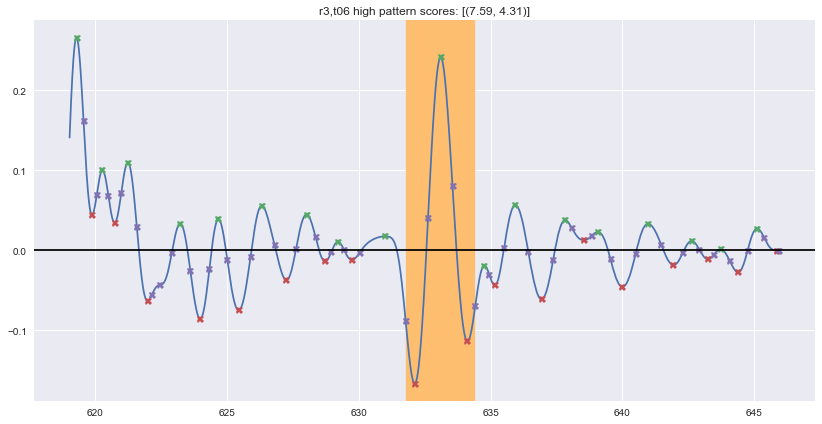

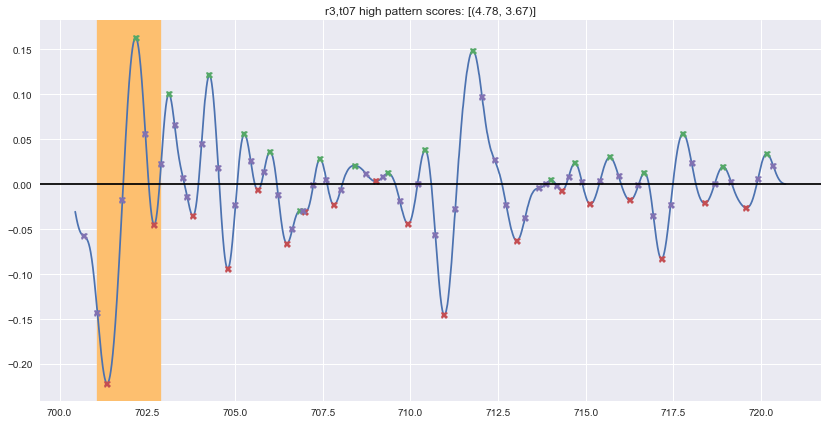

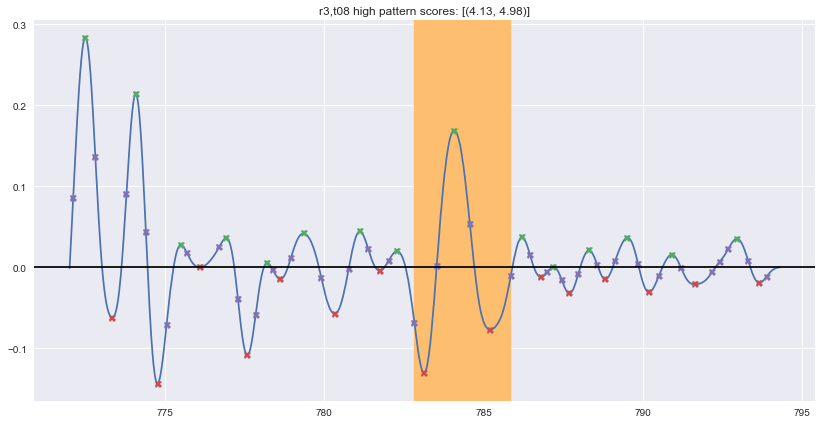

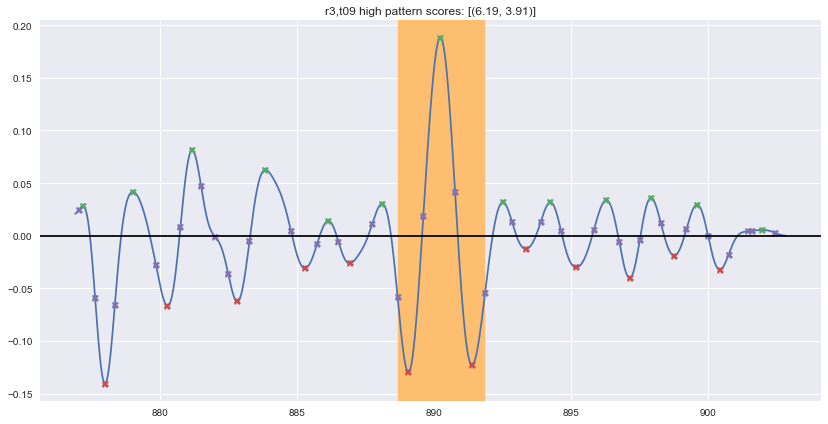

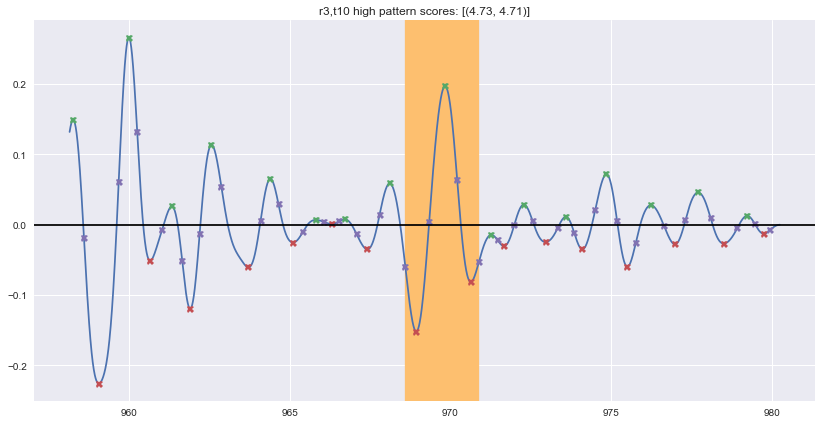

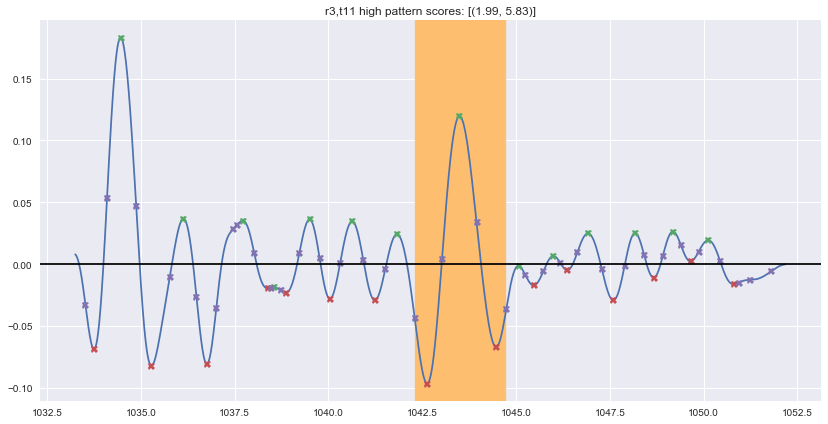

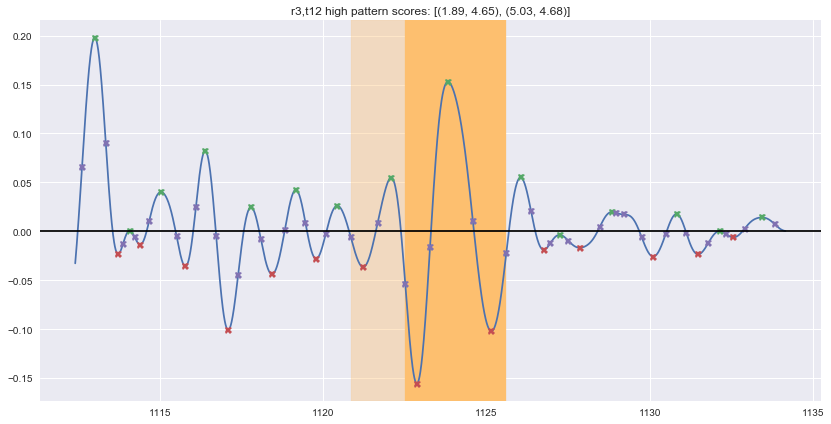

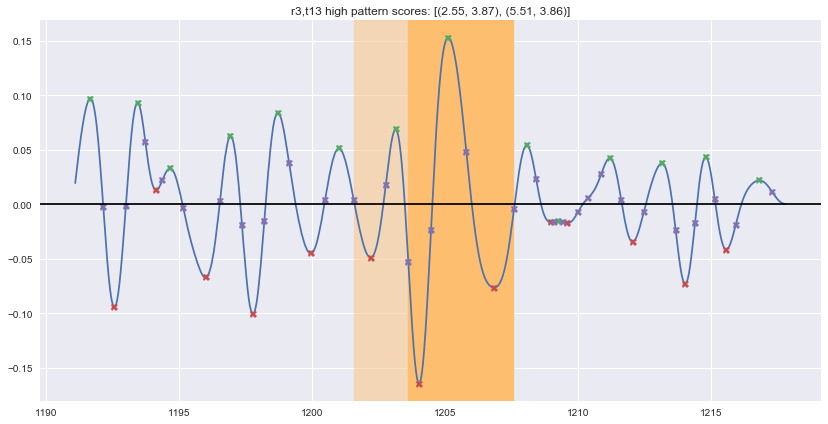

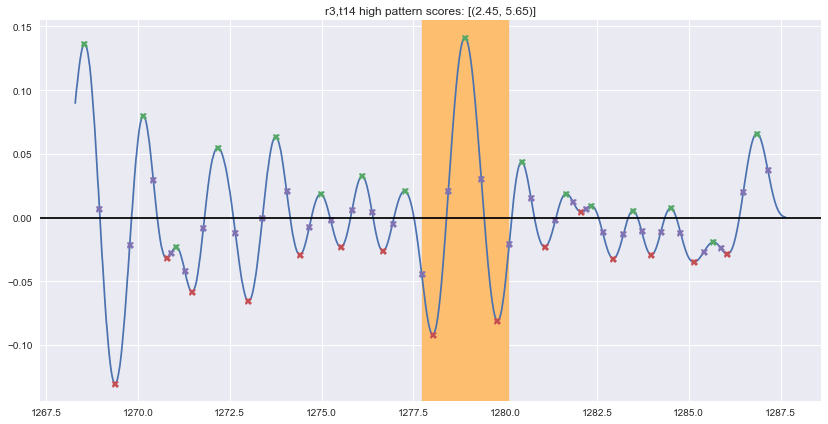

In [19]:
import numpy as np
import scipy.signal
import seaborn as sns
from cycler import cycler

steer_pattern = [
    Extremum.Concavity.INFLECT,
    Extremum.Concavity.MINIMUM,
    Extremum.Concavity.INFLECT,
    Extremum.Concavity.MAXIMUM,
    Extremum.Concavity.INFLECT,
    Extremum.Concavity.MINIMUM,
    Extremum.Concavity.INFLECT
]
    
    
def is_pattern(extrema_window, pattern):
    def is_sorted(window):
        a = window[0]
        for b in window[1:]:
            if a > b:
                return False
            a = b
        return True
        
    w = extrema_window
    if is_sorted(w) and len(w) == len(pattern):
        return all(a == b for (a, b) in zip(map(lambda x: x.concavity, iter(w)), 
                                            pattern))
    return False

def score_pattern(extrema_window, steer_angle_signal):
    """Calculate the integral of the signal in segments. Inflection points are
    used to split the signal into segments. The integral of each segment is
    multiplied by the minimum or maximum value in that segment.
    
    If maxima are negative or minima are positive, zero is returned.
    """
    w = extrema_window
    s = steer_angle_signal
    
    if (s[w[1].index] > 0 or
        s[w[3].index] < 0 or
        s[w[5].index] > 0):
        return 0
    
    score = (s[w[1].index] * s[w[0].index:w[2].index].sum() + 
             s[w[3].index] * s[w[2].index:w[4].index].sum() + 
             s[w[5].index] * s[w[4].index:w[6].index].sum())
    return score

plt.close()
for rid in range(4):
    r = records[rid]
    for tid in range(15):
        trial = r.trial(tid)
        filtered_steer_angle = r.filtered_steer_angle(trial)
        
        maxima = scipy.signal.argrelmax(filtered_steer_angle)[0]
        minima = scipy.signal.argrelmin(filtered_steer_angle)[0]
        
        steer_rate = np.diff(filtered_steer_angle)
        inflections = np.concatenate(
            (scipy.signal.argrelmin(steer_rate)[0],
             scipy.signal.argrelmax(steer_rate)[0]))
        
        extrema = list(zip(maxima,
                           [Extremum.Concavity.MAXIMUM] * len(maxima),
                           filtered_steer_angle[maxima]))
        extrema.extend(list(zip(minima,
                                [Extremum.Concavity.MINIMUM] * len(minima),
                                filtered_steer_angle[minima])))
        extrema.extend(list(zip(inflections,
                                [Extremum.Concavity.INFLECT] * len(inflections),
                                filtered_steer_angle[inflections])))
        extrema.sort() # python tuple sort
        extrema = [Extremum(index, concavity, value) for index, concavity, value in extrema]
        
        fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
        ax.plot(trial.time, filtered_steer_angle)
        ax.plot(trial.time[maxima], filtered_steer_angle[maxima], 'X')
        ax.plot(trial.time[minima], filtered_steer_angle[minima], 'X')
        ax.plot(trial.time[inflections], filtered_steer_angle[inflections], 'X')
        ax.axhline(0, color='black')
        
        starttime = []
        endtime = []
        score = []
        speed = []
        for w in window(extrema, len(steer_pattern)):
            if is_pattern(w, steer_pattern):
                starttime.append(trial.time[w[0].index])
                endtime.append(trial.time[w[-1].index])
                score.append(score_pattern(w, filtered_steer_angle))
                speed.append(trial.speed[w[0].index:w[-1].index].sum() /
                             (w[-1].index - w[0].index))
        starttime = np.array(starttime)
        endtime = np.array(endtime)
        score = np.array(score)
        speed = np.array(speed)
                
        # Filter out patterns less than 0.3 of max score
        index = score > (0.3 * score.max())
        starttime = starttime[index]
        endtime = endtime[index]
        score = score[index]
        speed = speed[index]
        
        # Filter out patterns with average speed less than 0.9 of max average speed
        index = speed > (0.9 * speed.max())
        starttime = starttime[index]
        endtime = endtime[index]
        score = score[index]
        speed = speed[index]
        
        colors = sns.color_palette('Paired', 10)[::2]
        
        for t0, t1, sc, sp in zip(starttime, endtime, score, speed):
            ax.axvspan(t0, t1, alpha=max(0, sc/score.max()), color=colors[3])
            
        ax.set_title('r{},t{:02d} high pattern scores: [{}]'.format(
            rid,
            tid,
            ', '.join('({:0.2f}, {:0.2f})'.format(sc, sp)
                      for sc, sp in zip(score, speed))))
        
plt.show()